# MNIST with CNN

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  
**Description:** this notebook uses the MNIST database to perform a supervised learning with the aim of image classification of handwritten digits.

## 1. Libraries and packages

In [0]:
!pip install -q \
    numpy       \
    torch       \
    sklearn     \
    skorch      \
    matplotlib  

In [0]:
#-------------------------------------------------
# general
#-------------------
#import pandas as pd
#import numpy as np
#-------------------------------------------------
# PyTorch
#-------------------
import torch
import torchvision
import torch.nn.functional as F
#-------------------------------------------------
# skorch
#-------------------
#from skorch import NeuralNetClassifier
#-------------------------------------------------
# scikit-learn
#-------------------
# preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder
# model_selection
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
#from sklearn.model_selection import GridSearchCV
# metrics
#from sklearn.metrics import \
#    confusion_matrix,       \
#    f1_score,               \
#    roc_curve,              \
#    roc_auc_score,          \
#    classification_report
# utils
#from sklearn.utils import shuffle
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
#import seaborn as sns
#from IPython import display
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
torch.manual_seed(42);
#use fixed point notation
#np.set_printoptions(suppress=True)

## 2. Dataset loading

### 2.1 PyTorch dataset creation

In [0]:
# transforms
pil2tensor = torchvision.transforms.ToTensor()
tensor2pil = torchvision.transforms.ToPILImage()
#-------------------------------------------------
# new reshape transform
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size
    def __call__(self, img):
        return torch.reshape(img, self.new_size)
#-------------------
mnist_transforms = [
    pil2tensor,
#    ReshapeTransform((-1,))
]
#-------------------------------------------------
ds = torchvision.datasets.MNIST('sample_data', download=True, transform=torchvision.transforms.Compose(mnist_transforms))

In [0]:
ds_train, ds_val, ds_dummy = torch.utils.data.random_split(ds, (10000, 2000, 48000))

### 2.2 PyTorch loader creation

- BATCH_SIZE definition
- training dataset
- validation dataset

In [5]:
BATCH_SIZE = 500
dl_train = torch.utils.data.DataLoader(
              dataset=ds_train, 
              batch_size = BATCH_SIZE, 
              drop_last = True,
              shuffle=True)
dl_val   = torch.utils.data.DataLoader(
              dataset = ds_val,
              drop_last = True,
              batch_size = BATCH_SIZE)

tx, ty = iter(dl_train).next()
print('train:', tx.shape,tx.dtype,ty.shape,ty.dtype)
tx, ty = iter(dl_val).next()
print('train:', tx.shape,tx.dtype,ty.shape,ty.dtype)
print('tamanho último batch:', len(ds_train)%BATCH_SIZE, len(ds_val)%BATCH_SIZE)

train: torch.Size([500, 1, 28, 28]) torch.float32 torch.Size([500]) torch.int64
train: torch.Size([500, 1, 28, 28]) torch.float32 torch.Size([500]) torch.int64
tamanho último batch: 0 0


### 2.3 Verifying shape, batch data type from loader and optionally its visualization

## 3. Network Model

### 3.1 Network class definition

In [0]:
'''
#-------------------------------------------------
1st layer: 'conv1' [convolution]
  - in_channels = 1
  - out_channels = 10
  - kernel_size = (5,5)
  - stride = 1
#-------------------
2nd layer: 'mp1' [subsampling]
  - kernel_size = (2,2)
  - stride = 2
#-------------------
3rd layer: 'conv2' [convolution]
  - in_channels = 10
  - out_channels = 30
  - kernel_size = (6,6)
  - stride = 1
#-------------------
4th layer: 'mp2' [subsampling]
  - kernel_size = (2,2)
  - stride = 2
#-------------------
fc1 (3rd layer): in_channels = (1,28,28), out_channels = (20,28,28)
fc2 (4th layer): output layer: 100 input, 10 output
#=================================================
conv1:   1x28x28 --> 10@24x24 (5x5 kernel)
mp1:    10@24x24 --> 10@12x12 (2x2 kernel)
conv2:  10@12x12 --> 30@6x6   (7x7 kernel)
mp2:    30@6x6   --> 30@3x3   (2x2 kernel)
conv3:  30@3x3   --> 100@1x1  (3x3 kernel)
#-------------------
fc1: 100 --> 30
fc2: 30 --> 10
'''

class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=(5,5), stride=1)
        self.mp1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = torch.nn.Conv2d(10, 30, kernel_size=(7,7), stride=1)
        self.mp2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv3 = torch.nn.Conv2d(30, 100, kernel_size=(3,3), stride=1)
        self.fc1 = torch.nn.Linear(in_features=100, out_features=30)
        self.fc2 = torch.nn.Linear(in_features=30, out_features=10)
        #self.Dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        #-------------------
        # convolutional layer, ReLU
        x = self.conv1(x)
        x = F.relu(x)
        # max-pooling
        x = self.mp1(x)
        #-------------------
        # convolutional layer, ReLU
        x = self.conv2(x)
        x = F.relu(x)
        # max-pooling
        x = self.mp2(x)
        #-------------------
        # convolutional layer, ReLU
        x = self.conv3(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        #-------------------
        # dense layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #-------------------
        return x

### 3.2 Network instantiation

In [0]:
model = NN()

In [0]:
# check if GPU is available
#model.cuda()

### 3.3 Network predict with few samples of batch from loader

In [9]:
model(iter(dl_train).next()[0])

tensor([[ 0.0157,  0.1716, -0.1263,  ...,  0.1207, -0.0663, -0.1332],
        [ 0.0132,  0.1709, -0.1283,  ...,  0.1140, -0.0671, -0.1437],
        [ 0.0082,  0.1836, -0.1264,  ...,  0.1200, -0.0613, -0.1322],
        ...,
        [ 0.0254,  0.1637, -0.1376,  ...,  0.1329, -0.0688, -0.1263],
        [ 0.0064,  0.1754, -0.1293,  ...,  0.1123, -0.0665, -0.1404],
        [ 0.0084,  0.1758, -0.1340,  ...,  0.1241, -0.0672, -0.1340]],
       grad_fn=<AddmmBackward>)

## 4. Network training

### 4.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
# Training parameters
EPOCH = 50
LR = 0.05
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
# loss history
loss_his = []
loss_val_his = []

### 4.2 Training loop

In [11]:
N_SAMPLES = len(ds_train)
for epoch in range(EPOCH):
    print('epoch =', epoch, end='; ')
    #-------------------------------------------------
    # training
    model.train()
    zero_one_loss = 0.
    for b_i, (b_x, b_y) in enumerate(dl_train):   # for each training step
        y_pred = model(b_x)
        loss = loss_func(y_pred, b_y)
        opt.zero_grad()                 # clear gradients for next train
        loss.backward()                 # backpropagation, compute gradients
        opt.step()                      # apply gradients
    #-------------------
    max_polling = torch.argmax(y_pred, dim=1)
    zero_one_loss += (b_y == max_polling).sum()
    acc_train = zero_one_loss / len(y_pred)
    #-------------------------------------------------
    # validation
    model.eval()
    zero_one_loss_val = 0.
    for b_ival, (b_xval, b_yval) in enumerate(dl_val):
        y_logitos = model(b_xval)
        loss_val = loss_func(y_logitos, b_yval)
        yval_pred = torch.argmax(y_logitos, dim=1)
        zero_one_loss_val += (b_yval == yval_pred).sum()
    #-------------------------------------------------
    loss_his.append(loss.item())    # loss recoder
    loss_val_his.append(loss_val.item())    # loss recoder
    acc_val = zero_one_loss_val / len(ds_val)
    #-------------------------------------------------
    print('loss_train = {0:.4f}'.format(loss_his[-1]), end='; ')
    print('loss_val = {0:.4f}'.format(loss_val_his[-1]), end='; ')
    print('acc_train = {0:.4f}'.format(acc_train), end='; ')
    print('acc_val = {0:.4f}'.format(acc_val), end='\n')

epoch = 0; loss_train = 2.3062; loss_val = 2.3036; acc_train = 0.1060; acc_val = 0.1095
epoch = 1; loss_train = 2.3075; loss_val = 2.3001; acc_train = 0.1160; acc_val = 0.1095
epoch = 2; loss_train = 2.2958; loss_val = 2.2970; acc_train = 0.1200; acc_val = 0.1095
epoch = 3; loss_train = 2.2915; loss_val = 2.2933; acc_train = 0.1060; acc_val = 0.1095
epoch = 4; loss_train = 2.2843; loss_val = 2.2887; acc_train = 0.1320; acc_val = 0.1215
epoch = 5; loss_train = 2.2818; loss_val = 2.2825; acc_train = 0.2160; acc_val = 0.1860
epoch = 6; loss_train = 2.2745; loss_val = 2.2730; acc_train = 0.2200; acc_val = 0.2270
epoch = 7; loss_train = 2.2537; loss_val = 2.2552; acc_train = 0.3120; acc_val = 0.2875
epoch = 8; loss_train = 2.2200; loss_val = 2.2141; acc_train = 0.3240; acc_val = 0.3310
epoch = 9; loss_train = 2.1068; loss_val = 2.0967; acc_train = 0.3420; acc_val = 0.3515
epoch = 10; loss_train = 1.7162; loss_val = 1.7186; acc_train = 0.4660; acc_val = 0.5160
epoch = 11; loss_train = 1.5065

## 5. Performance evaluation

- metrics:
  - accuracy
  - confusion matrix
  - others

### Training Loss

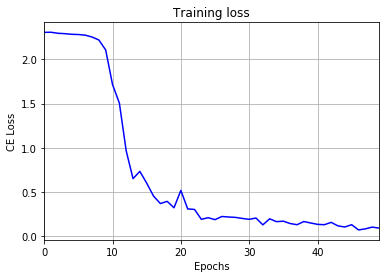

In [12]:
# plot training loss
plt.plot(loss_his, label='training loss', color='blue')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Training loss')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### Validation Loss

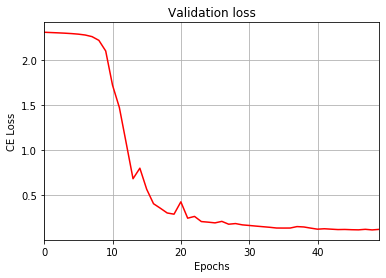

In [13]:
# plot validation loss
plt.plot(loss_val_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Validation loss')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### Zoom at the minimum of CE loss curve

Epoch with minimum validation loss = 49


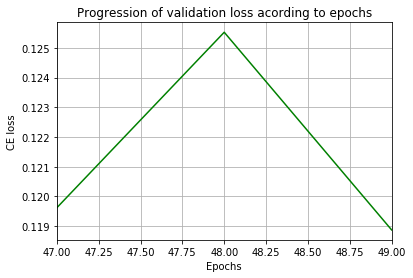

In [14]:
best_epoch = loss_val_his.index(min(loss_val_his)) + 1
print('Epoch with minimum validation loss =', best_epoch)
#-------------------------------------------------
# plots
plt.plot(range(max(1,best_epoch-2),min(EPOCH,best_epoch+3)), loss_val_his[max(1,best_epoch-3):min(EPOCH-1,best_epoch+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('CE loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of validation loss acording to epochs')
plt.grid(True)
plt.show()

### 5.1 Print the final values of the main training monitoring variables:
- loss function final value:
- metrics final values:

In [15]:
print('last training loss = {0:.4f}'.format(loss_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_val_his[-1]))
#-------------------------------------------------
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train.item()))
print('last validation accuracy = {0:.4f}'.format(acc_val.item()))

last training loss = 0.0928
last validation loss = 0.1246
#-------------------------------------------------
last train accuracy = 0.9680
last validation accuracy = 0.9640
